# Dataset y librerias

Librerias

In [ ]:
import pandas as pd # para csv
import matplotlib.pyplot as plt # para gráficos
import numpy as np
import tensorflow as tf
import random # para reproducibilidad
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from copy import deepcopy
from sklearn.linear_model import LinearRegression

En este caso utilizaremos un dataset  extraído de https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip que es una serie temporal sobre datos climáticos de la ciudad de Jena, Alemania.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-08 17:00:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.198.104, 52.216.48.56, 16.182.71.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.198.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.02MB/s    in 2.1s    

2025-04-08 17:00:07 (6.02 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Ahora, cargo el archivo

In [ ]:
df = pd.read_csv("jena_climate_2009_2016.csv")
print(df.head())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

Realizo el gráfico de la temperatura

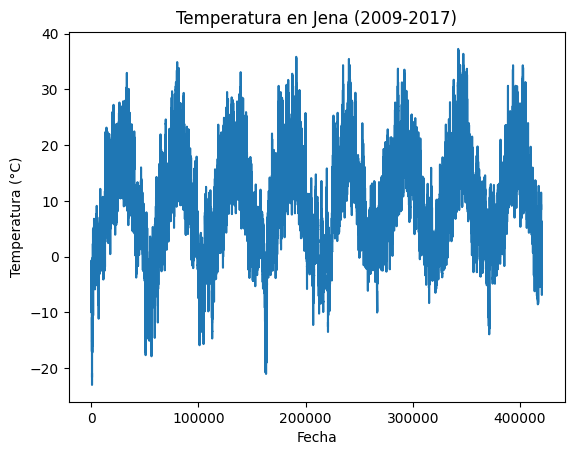

In [ ]:
plt.plot(df.index, df["T (degC)"])
plt.title("Temperatura en Jena (2009-2017)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.show()

# Preprocesamiento de los datos

Fijar las semillas para reproducibilidad

In [ ]:
# Fijar semillas para control de aleatoriedad
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

* Explicación de cualquier preprocesamiento o técnica adicional utilizada.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


Podemos observar que tenemos las siguientes variables de interés:  
\
\begin{array}{|c|c|}
\hline
\textbf{Variable} & \textbf{Descripción} \\
\hline
p (mbar) & \text{Presión atmosférica en milibares} \\
\hline
T (degC) & \text{Temperatura en grados centígrados} \\
\hline
Tpot (K) & \text{Temperatura potencial en kelvin} \\
\hline
Tdew (degC) & \text{Temperatura del punto de rocío en grados centígrados} \\
\hline
rh (\%) & \text{Humedad relativa en porcentaje} \\
\hline
VPmax (mbar) & \text{Presión de vapor máxima en milibares} \\
\hline
VPact (mbar) & \text{Presión de vapor actual en milibares} \\
\hline
VPdef (mbar) & \text{Deficiencia de presión de vapor en milibares} \\
\hline
sh (g/kg) & \text{Humedad específica en gramos por kilogramo} \\
\hline
H2OC (mmol/mol) & \text{Concentración de vapor de agua en milimoles por mol} \\
\hline
rho (g/m^3) & \text{Densidad del aire en gramos por metro cúbico} \\
\hline
wv (m/s) & \text{Velocidad del viento en metros por segundo} \\
\hline
max. wv (m/s) & \text{Velocidad máxima del viento en metros por segundo} \\
\hline
wd (deg) & \text{Dirección del viento en grados} \\
\hline
\end{array}

Convierto la columnna fecha a tipo datetime

In [ ]:
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date Time", inplace=True)  # Establecer fecha como índice

Normalizo los datos

In [ ]:
# MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.814939,0.248632,0.243662,0.334788,0.923033,0.037886,0.084272,0.004782,0.081679,0.082798,0.743213,0.070403,0.074468,0.423056
2009-01-01 00:20:00,0.815430,0.242163,0.237241,0.326891,0.924182,0.036294,0.081003,0.004564,0.078843,0.079586,0.749349,0.049214,0.063830,0.378056
2009-01-01 00:30:00,0.815037,0.240504,0.235594,0.326268,0.929925,0.035976,0.080639,0.004347,0.078276,0.079229,0.750666,0.012987,0.026809,0.476667
2009-01-01 00:40:00,0.814840,0.243822,0.239052,0.331255,0.933372,0.036772,0.082819,0.004130,0.080545,0.081370,0.747523,0.023240,0.021277,0.550000
2009-01-01 00:50:00,0.814840,0.244485,0.239546,0.331879,0.932223,0.036931,0.083182,0.004130,0.080545,0.081727,0.746954,0.021873,0.026809,0.595278


In [ ]:
df_scaled_new = df_scaled.drop(['p (mbar)', 'rh (%)'], axis=1)
df_scaled_new.head()

,T (degC),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,
2009-01-01 00:10:00,0.248632,0.243662,0.334788,0.037886,0.084272,0.004782,0.081679,0.082798,0.743213,0.070403,0.074468,0.423056
2009-01-01 00:20:00,0.242163,0.237241,0.326891,0.036294,0.081003,0.004564,0.078843,0.079586,0.749349,0.049214,0.063830,0.378056
2009-01-01 00:30:00,0.240504,0.235594,0.326268,0.035976,0.080639,0.004347,0.078276,0.079229,0.750666,0.012987,0.026809,0.476667
2009-01-01 00:40:00,0.243822,0.239052,0.331255,0.036772,0.082819,0.004130,0.080545,0.081370,0.747523,0.023240,0.021277,0.550000
2009-01-01 00:50:00,0.244485,0.239546,0.331879,0.036931,0.083182,0.004130,0.080545,0.081727,0.746954,0.021873,0.026809,0.595278


# Gráficos normalizados (más informativo)

Una vez normalizados los datos volvamos a graficarlos para cada variable

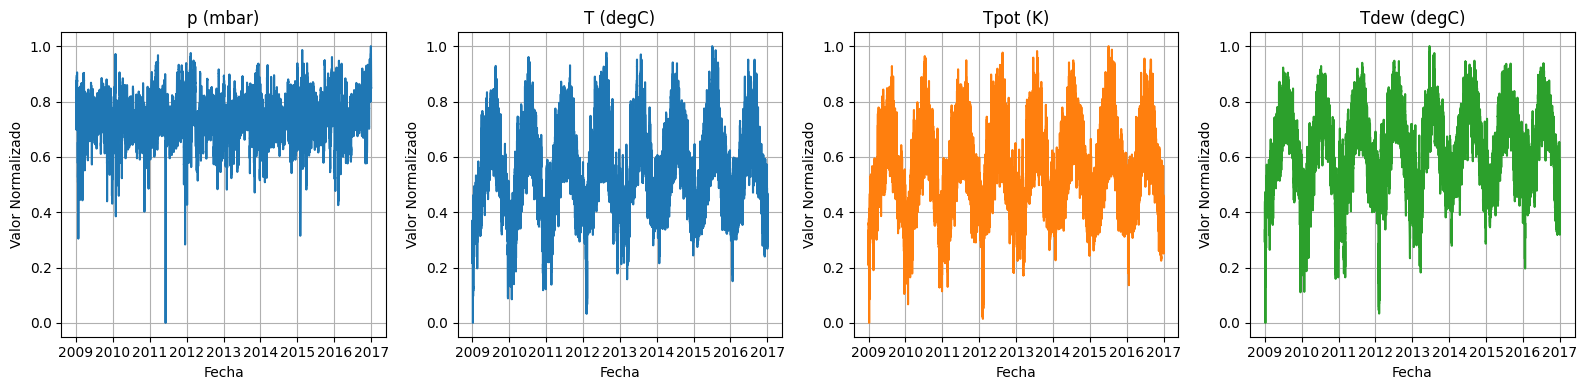

In [ ]:
num_vars = len(df_scaled.columns)
nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), sharex=True)

colors = plt.get_cmap("tab10")(np.linspace(0, 1, num_vars))

# Aplanar la matriz de ejes si hay múltiples filas y columnas
axes = axes.flatten() if num_vars > 1 else [axes]

# Iterar sobre cada variable y su respectivo subplot
for ax, col, color in zip(axes, df_scaled.columns, colors):
    ax.plot(df_scaled.index, df_scaled[col], color=color)
    ax.set_title(col)
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Valor Normalizado")
    ax.grid(True)

# Ajustar espaciado para que los títulos no se superpongan
plt.tight_layout()

plt.show()

Ahora con todas las variables en un mismo gráfico

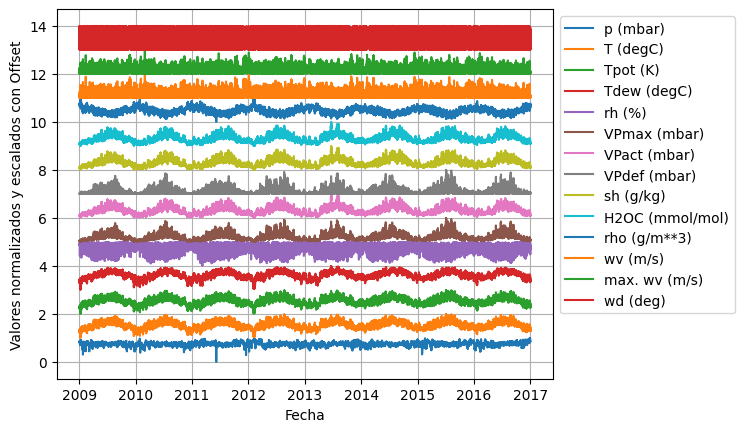

In [ ]:
# Ajustar el tamaño del gráfico
#plt.figure(figsize=(18, 10))

# Iterar sobre todas las columnas del dataframe
for i, col in enumerate(df_scaled.columns):
    plt.plot(df_scaled.index, df_scaled[col] + i * 1, label=col)  # Offset para separar las líneas

# Configuración del gráfico
#plt.title("Evolución de todas las variables en Jena (2009-2017)")
plt.xlabel("Fecha")
plt.ylabel("Valores normalizados y escalados con Offset")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()

# Modelo Univariado

Creo las ventanas de tiempo de datos pasados para predecir los futuros

In [ ]:
# Secuencia Univariada
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])  # Predice el siguiente valor
    return np.array(X), np.array(y)

seq_length = 30  # Ejemplo: usar 30 pasos atrás
X, y = create_sequences(df_scaled["T (degC)"].values, seq_length) ### CAMBIEESTO

Spliteo los datos (no se usa train_test_split en series temporales)

In [ ]:
# División en entrenamiento, validación y prueba (60%, 20%, 20%)
train_size = int(0.6 * len(X))  # 60% entrenamiento
val_size = int(0.2 * len(X))   # 20% validación

# Divisiones
X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

# Ahora dividimos el 20% restante en validación y prueba
X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

# Ver las formas de las matrices
print(f"Train Matrix Shape: {X_train.shape}")
print(f"Validation Matrix Shape: {X_val.shape}")
print(f"Test Matrix Shape: {X_test.shape}")

Train Matrix Shape: (252252, 30)
Validation Matrix Shape: (84084, 30)
Test Matrix Shape: (84085, 30)


Les doy la forma correcta

In [ ]:
# Asegurar que los datos tengan la forma correcta para el entrenamiento
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print(f"Train Matrix Shape: {X_train.shape}")
print(f"Test Matrix Shape: {X_test.shape}")
print(f"Val Matrix Shape: {X_val.shape}")

Train Matrix Shape: (252252, 30, 1)
Test Matrix Shape: (84085, 30, 1)
Val Matrix Shape: (84084, 30, 1)


Reduzco el tamaño de mis datos de entrenamiento

In [ ]:
fraction = 0.2  # Usa solo el 20% de los datos
subset_size = int(len(X_train) * fraction)

X_train = X_train[:subset_size]
y_train = y_train[:subset_size]

print(f"Train Matrix Shape: {X_train.shape}")
print(f"Test Matrix Shape: {X_test.shape}")
print(f"Val Matrix Shape: {X_val.shape}")

Train Matrix Shape: (50450, 30, 1)
Test Matrix Shape: (84085, 30, 1)
Val Matrix Shape: (84084, 30, 1)


In [ ]:
plt.rcParams.update({'axes.labelsize': 16})  # Cambia el tamaño de los labels de los ejes en todos los gráficos


Entreno mi modelo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0040 - val_loss: 1.9305e-05
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 2.3684e-05 - val_loss: 1.5848e-05
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 1.8770e-05 - val_loss: 1.4617e-05
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 1.6942e-05 - val_loss: 1.2603e-05
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.5406e-05 - val_loss: 1.5060e-05
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.5932e-05 - val_loss: 1.1104e-05
Epoch 7/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.5895e-05 - val_loss: 1.1681e-05
Epoch 8/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.5989e-05 - val_loss: 1.0901e-05
Epoch 9/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.5788e-05 - val_loss: 1.0994e-05
Epoch 10/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.5643e-05 - val_loss: 1.1016e-05


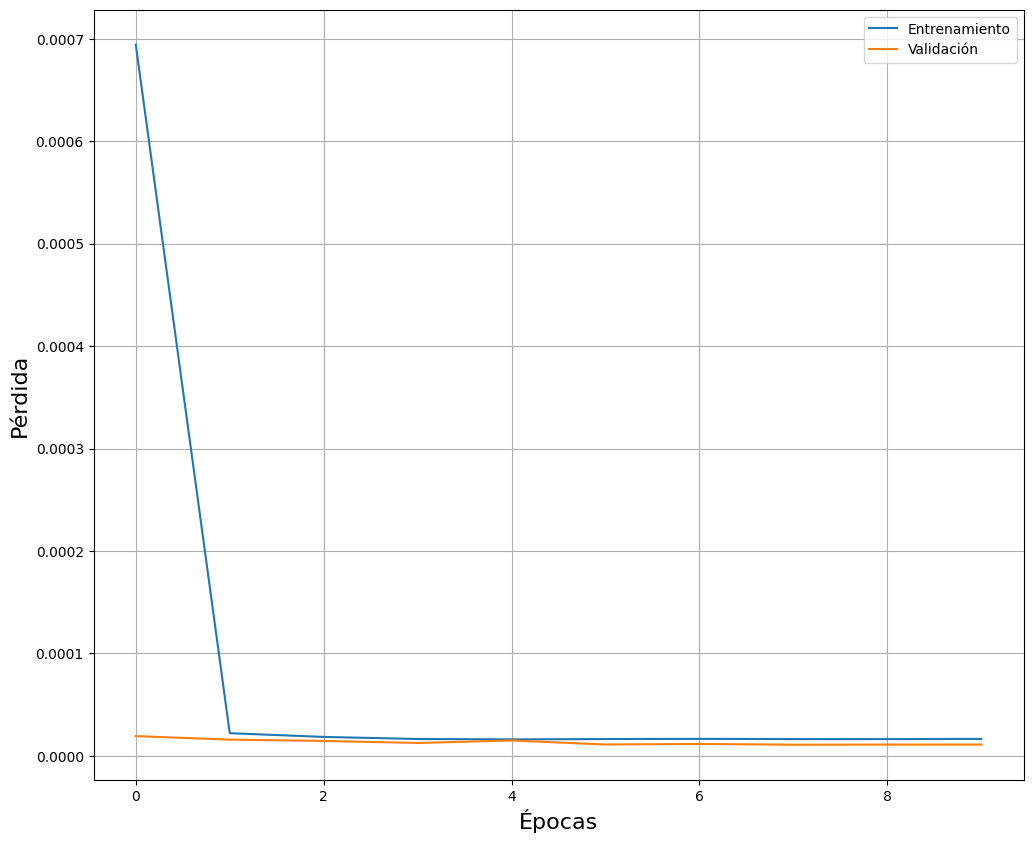

In [ ]:
# Definir el modelo
model = Sequential([
    SimpleRNN(50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation="relu"),
    Dense(1)  # Salida univaluada (predice temperatura)
])

# Compilar el modelo
model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Graficar las curvas de pérdida
plt.figure(figsize=(12, 10))

# Pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')

#plt.title('Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()
plt.legend()

plt.show()

Lo pruebo en mi conjunto de test

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Error Absoluto Medio (MAE): 0.13
Raíz del Error Cuadrático Medio (RMSE): 0.21


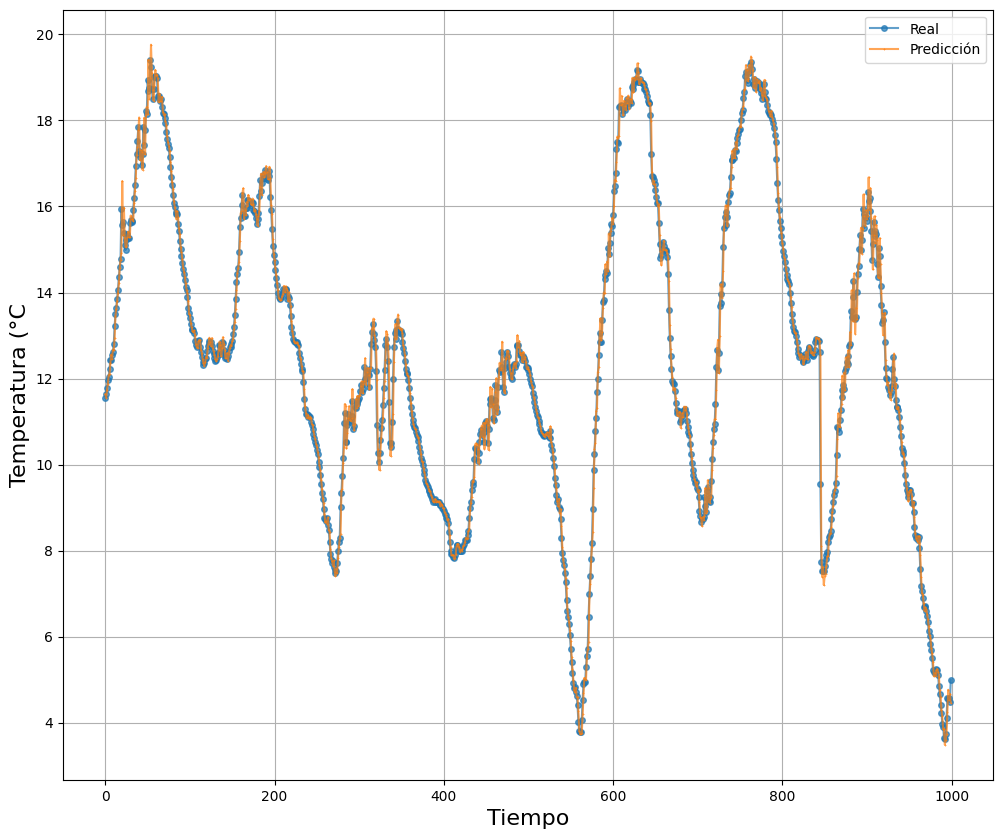

<Figure size 640x480 with 0 Axes>

In [ ]:
# Predicciones
y_pred = model.predict(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(df[["T (degC)"]])  # Entrenar solo con la columna objetivo

# Desnormalizar
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_y.inverse_transform(y_pred)

# Calcular MAE y RMSE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

# Mostrar las métricas
print(f"Error Absoluto Medio (MAE): {round(mae, 2)}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {round(rmse, 2)}")

# Graficar predicciones vs valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(y_test_actual[:1000], label="Real",markersize=4, marker='o', alpha=0.7)
plt.plot(y_pred_actual[:1000], label="Predicción", alpha=0.7, markersize=0.7, marker='x')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C')
#plt.title("Predicción de temperatura usando RNN Univariada")
plt.grid()
plt.figure()
plt.show()



---



---



# Modelo Multivariado

Creo las ventanas de tiempo de datos pasados para predecir los futuros

In [ ]:
# Secuencias multivariadas
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])  # Predice el siguiente valor
    return np.array(X), np.array(y)

seq_length = 30  # Usamos 30 pasos de tiempo
X, y = create_sequences_multivariate(df_scaled.values, seq_length) # CAMBIE ESTO

Spliteo los datos

In [ ]:
# División en entrenamiento, validación y prueba (60%, 20%, 20%)
train_size = int(0.6 * len(X))  # 60% entrenamiento
val_size = int(0.2 * len(X))   # 20% validación

# Divisiones
X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

# Ahora dividimos el 20% restante en validación y prueba
X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

# Ver las formas de las matrices
print(f"Train Matrix Shape: {X_train.shape}")
print(f"Validation Matrix Shape: {X_val.shape}")
print(f"Test Matrix Shape: {X_test.shape}")

Train Matrix Shape: (252252, 30, 14)
Validation Matrix Shape: (84084, 30, 14)
Test Matrix Shape: (84085, 30, 14)


Reduzco el tamaño de mis datos de entrenamiento

In [ ]:
fraction = 0.2  # Usa solo el 20% de los datos
subset_size = int(len(X_train) * fraction)

X_train = X_train[:subset_size]
y_train = y_train[:subset_size]

print(f"Train Matrix Shape: {X_train.shape}")
print(f"Test Matrix Shape: {X_test.shape}")
print(f"Val Matrix Shape: {X_val.shape}")

Train Matrix Shape: (50450, 30, 14)
Test Matrix Shape: (84085, 30, 14)
Val Matrix Shape: (84084, 30, 14)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0651 - val_loss: 0.0599
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 7/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 8/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 9/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 10/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0598 - val_loss: 0.0599


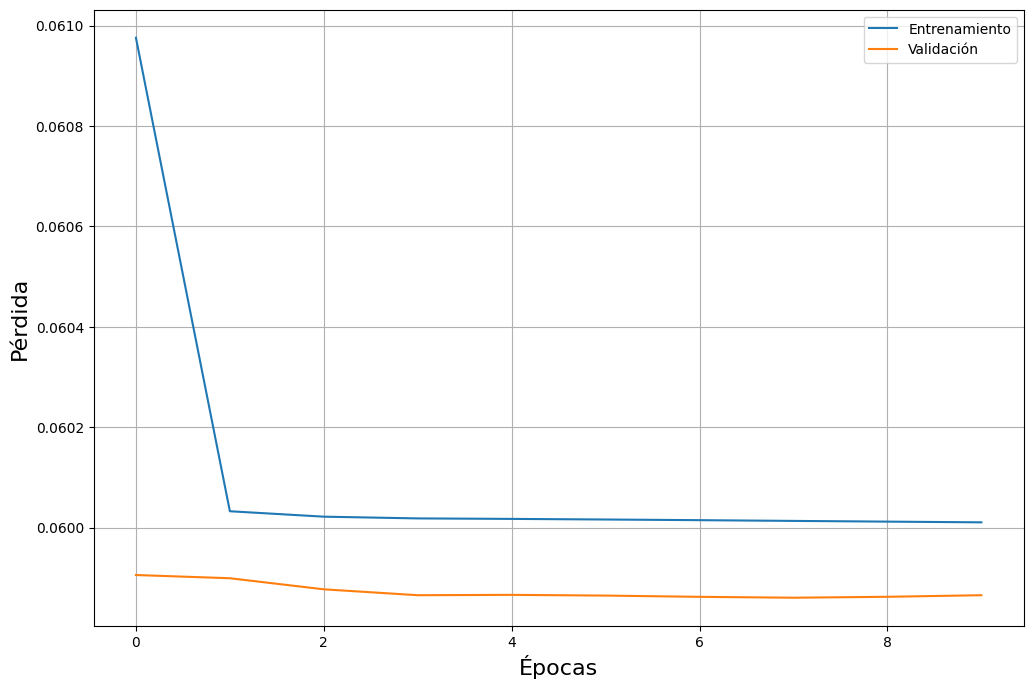

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Definir el modelo multivariado con LSTM
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation="relu"),
    Dense(1)  # Salida univaluada (predice temperatura)
])

# Compilar el modelo
model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Graficar las curvas de pérdida
plt.figure(figsize=(12, 8))

# Pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

plt.show()

Entreno mi modelo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0609 - val_loss: 0.0599
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 7/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 8/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 9/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0598 - val_loss: 0.0599
Epoch 10/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0598 - val_loss: 0.0599


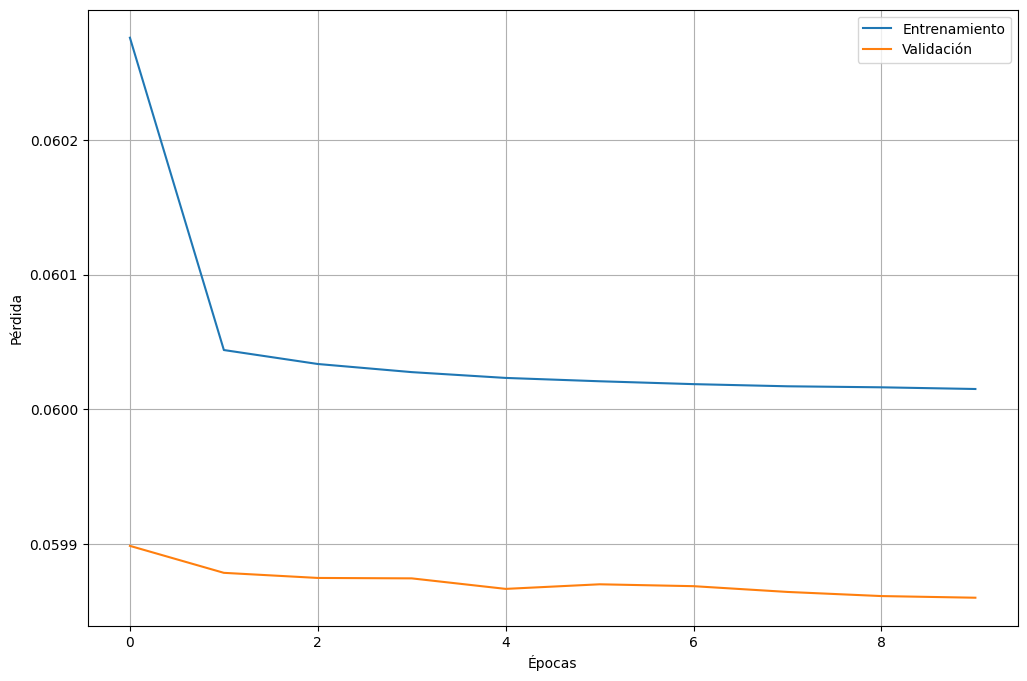

In [ ]:
# Definir el modelo multivariado
model = Sequential([
    SimpleRNN(50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation="relu"),
    Dense(1)  # Salida univaluada (predice temperatura)
])

# Compilar el modelo
model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Graficar las curvas de pérdida
plt.figure(figsize=(12, 8))

# Pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')

#plt.title('Curva de Pérdida durante el Entrenamiento (Multivariado)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

plt.show()

In [ ]:
y_test.shape

(84085, 14)

Lo pruebo en mi conjunto de test

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
(84085, 1)
Error Absoluto Medio (MAE): 0.34
Raíz del Error Cuadrático Medio (RMSE): 0.35


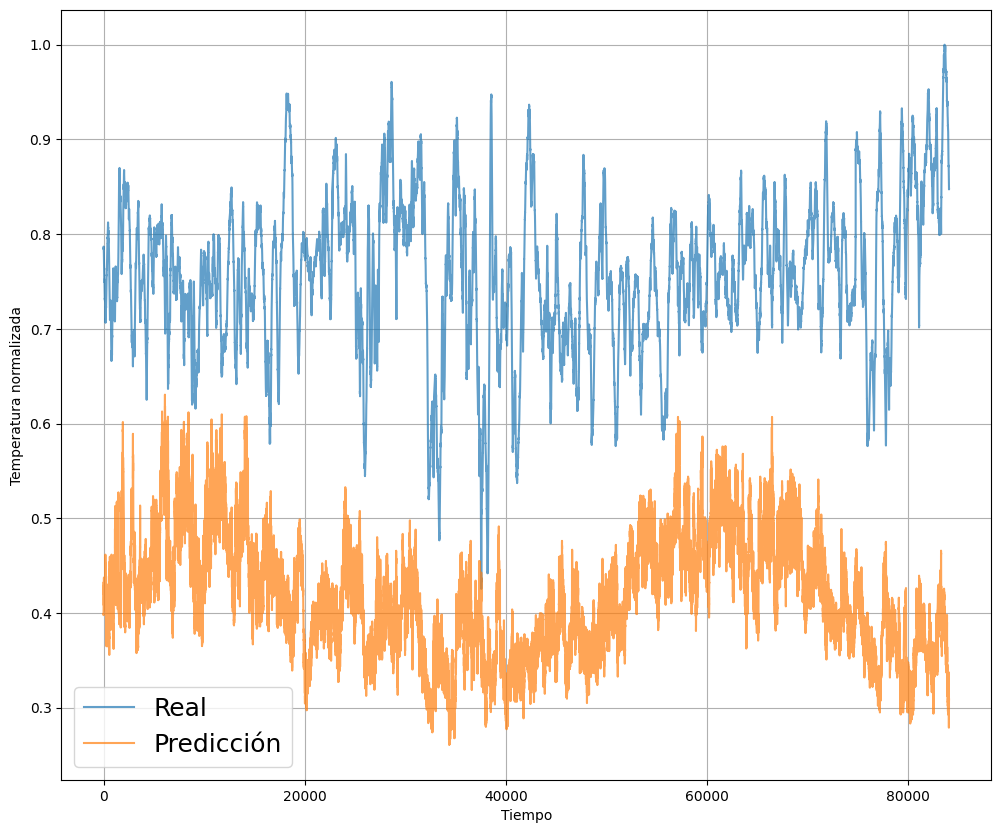

In [ ]:
# Predicciones
y_pred = model.predict(X_test)
print(y_pred.shape)

# Select the 'T (degC)' column (or the corresponding index) from y_test
y_test_temp = y_test[:, df_scaled_new.columns.get_loc("T (degC)")]

# Calcular métricas de error
mae = mean_absolute_error(y_test_temp, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_temp, y_pred))
rmse_lin_alg= mean_absolute_error(y_test_temp,y_pred)
mae_lin = np.sqrt(mean_squared_error(y_test_temp, y_pred))

# Mostrar las métricas
print(f"Error Absoluto Medio (MAE): {round(mae, 2)}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {round(rmse, 2)}")

# Graficar predicciones vs valores reales
plt.figure(figsize=(12,10))
plt.plot(y_test_temp, label="Real", alpha=0.7)
plt.plot(y_pred, label="Predicción", alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('Temperatura normalizada')
plt.legend(fontsize=18)
plt.grid()
#plt.title("Predicción de temperatura usando RNN Multivariada")
plt.show()

In [ ]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

print(f"Shape of y_test_actual: {y_test_actual.shape}") # Debe ser (84085, 1)
print(f"Shape of y_pred_actual: {y_pred_actual.shape}") # Debe ser (84085, 1)

Shape of X_test: (84085, 30, 12)
Shape of y_test: (84085, 12)
Shape of y_pred: (84085, 1)
Shape of y_test_actual: (84085, 1)
Shape of y_pred_actual: (84085, 1)


Importancia de las variables

In [ ]:
def permutation_importance(model, X_test, y_test, scaler_y):
    base_pred = model.predict(X_test)  # Predicciones originales
    base_error = mean_absolute_error(y_test, base_pred)  # Error base

    importances = []

    for i in range(X_test.shape[2]):  # Iterar sobre cada variable
        X_test_perm = deepcopy(X_test)  # Copiar datos
        np.random.shuffle(X_test_perm[:, :, i])  # Permutar solo la variable i

        print(f"Predicción realizada al permutar la variable [{i+1}/14]: {df.columns[i]}")  # Imprimir el nombre de la variable permutada

        y_pred_perm = model.predict(X_test_perm)  # Nueva predicción
        error = mean_absolute_error(y_test, y_pred_perm)  # Nuevo error

        importance = error - base_error  # Diferencia de error
        importances.append(importance)

    return np.array(importances)

# Calcular importancias
importances = permutation_importance(model, X_test, y_test_actual, scaler_y)

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [1/14]: p (mbar)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [2/14]: T (degC)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [3/14]: Tpot (K)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [4/14]: Tdew (degC)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [5/14]: rh (%)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [6/14]: VPmax (mbar)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [7/14]: VPact (mbar)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Predicción realizada al permutar la variable [8/14]: VPdef (mbar)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predicción realizada al permutar la variable [9/14]: sh (g/kg)
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/ste

Graficamos las importancias (mayor valor, mayor importancia de la variable)

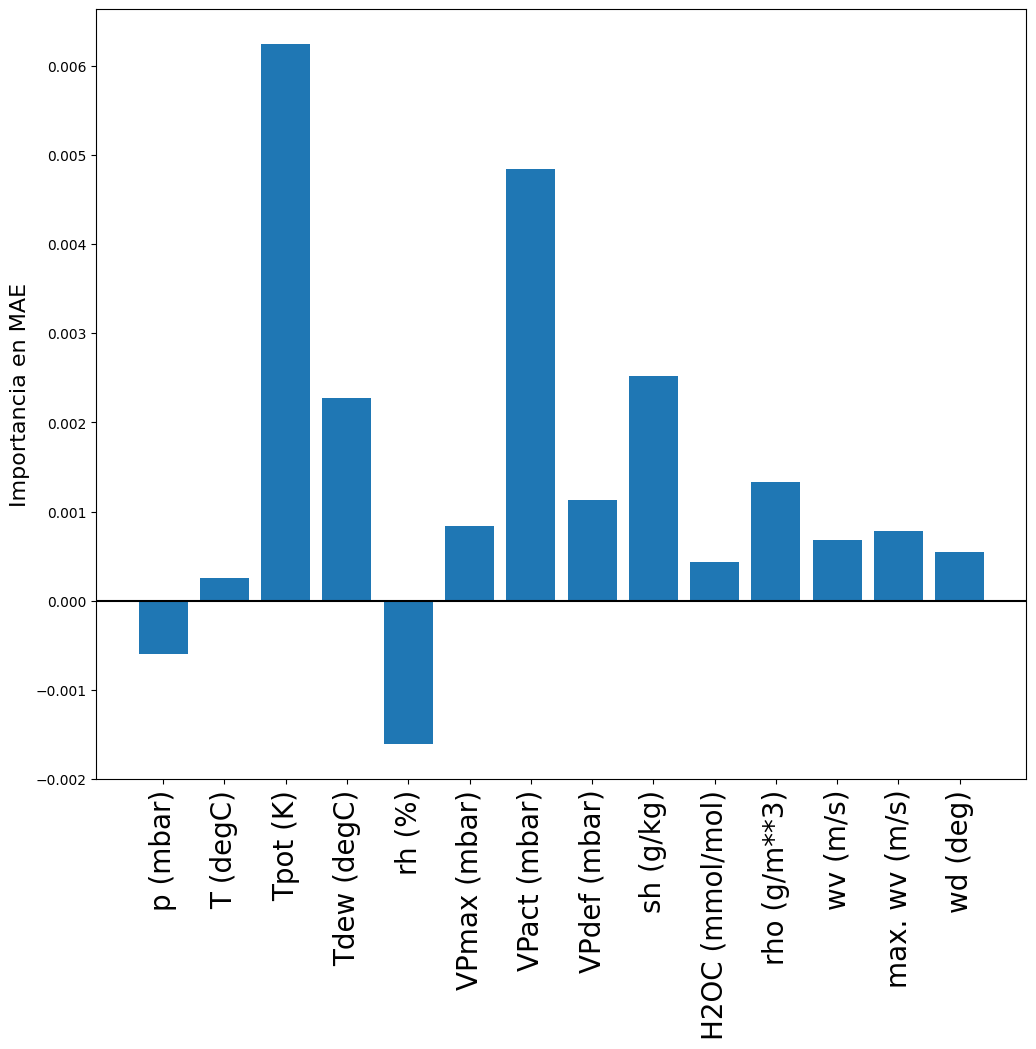

In [ ]:
# Graficar importancias
plt.figure(figsize=(12, 10))
plt.axhline(y=0, color='black')
plt.bar(range(X_test.shape[2]), importances)
plt.xticks(range(X_test.shape[2]), df.columns[:X_test.shape[2]], rotation=90, fontsize=20)  # Nombres de variables
plt.ylabel("Importancia en MAE")

#plt.title("Importancia de las Variables en la RNN")
plt.show()

- Si una variable tiene un alto valor de importancia, significa que al permutarla el error aumenta significativamente, por lo que es una variable clave en la predicción.
- Si una variable tiene un valor bajo o cercano a cero, significa que permutarla no afecta mucho al rendimiento del modelo, indicando que es poco relevante.
- Si una variable tiene un valor negativo (lo cual no es común, pero posible), significa que el modelo mejora cuando esa variable se permuta, lo que podría indicar que introduce ruido o sobreajuste.

---

Ahora tiro (permuto) las variables que no aportan y las que perjudican, es decir:
- rh
- presion

# Modelo de Regresión Lineal

Preparo los datos para que sean compatibles con el modelo de regresión lineal

In [ ]:
# Aplanar los datos de entrada para que sean compatibles con regresión lineal
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Pruebo el modelo

In [ ]:
# Modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train)

# Predicción y evaluación
y_pred_lin = lin_reg.predict(X_test_flat)

Verifico su dimensionalidad

In [ ]:
print(y_pred.shape)  # Probablemente (n_samples, 1)
print(y_pred_lin.shape)  # Probablemente (n_samples,)

(84085, 1)
(84085, 14)


Desnormalizo las predicciones

In [ ]:
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_pred_lin_actual = scaler_y.inverse_transform(y_pred_lin.reshape(-1, 1))

In [ ]:
print(y_test_actual.shape)
print(y_pred_actual.shape)
print(y_pred_lin_actual.shape)

(1177190, 1)
(84085, 1)
(1177190, 1)


 * Obtengo sus MAE y RMSE

In [ ]:
# Calcular MAE y RMSE
mae_lin = mean_absolute_error(y_test_actual, y_pred_lin_actual)
rmse_lin = np.sqrt(mean_squared_error(y_test_actual, y_pred_lin_actual))

# Mostrar las métricas
print(f"MAE de la regresión lineal: {round(mae_lin, 2)}")
print(f"Raíz del Error Cuadrático Medio (RMSE) de la Regresión Lineal: {round(rmse_lin, 2)}")


MAE de la regresión lineal: 0.72
Raíz del Error Cuadrático Medio (RMSE) de la Regresión Lineal: 2.63


* Realizo un gráfico comparando el modelo RNN y el RegLin

NameError: name 'y_pred_lin_actual' is not defined

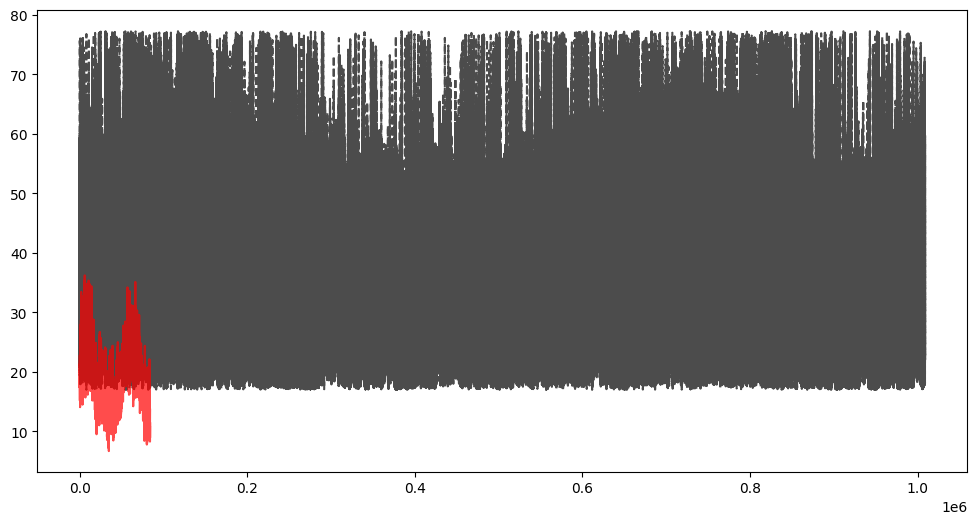

In [ ]:
offset = 20  # Define un desplazamiento entre las líneas

plt.figure(figsize=(12, 6))

# Graficar las tres series con offset
plt.plot(y_test_actual + 2*offset, label="Real", color="black", linestyle="dashed", alpha=0.7)
plt.plot(y_pred_actual + offset, label="Predicción RNN", color="red", alpha=0.7)
plt.plot(y_pred_lin_actual, label="Predicción Regresión Lineal", color="blue", alpha=0.7)

#plt.title("Comparación de Predicciones con Offset: RNN vs Regresión Lineal")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C) (Desplazada)")
plt.legend()
plt.grid(True)

plt.show()